# Phase 1 - (Convolutional) Neural Networks

Please follow the notebook in order. Make sure to add code where indicated by `''' TODO '''` or `# YOUR CODE HERE`. Ensure your notebook is easy to follow. All written report answers should be provided in the notebook itself.

You may find [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) pytorch tutorial helpful.

In [4]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

## 1. Loading & Visualizing Data

Please use MNIST for this Phase. MNIST is a digit classification dataset, with greyscale 28x28 images, and 10 classes (numbers 0-9). See [documentaion.](https://pytorch.org/vision/0.15/generated/torchvision.datasets.MNIST.html) You can also see the MNIST_Tutorial.ipynb

Please complete loading the data.

Please also complete `show_imgs()`. Function should input the dataloader, and show random 10 images and their labels as title to plot. Make sure the 10 images are organized in a grid or format or with matplotlib axis.

In [5]:
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

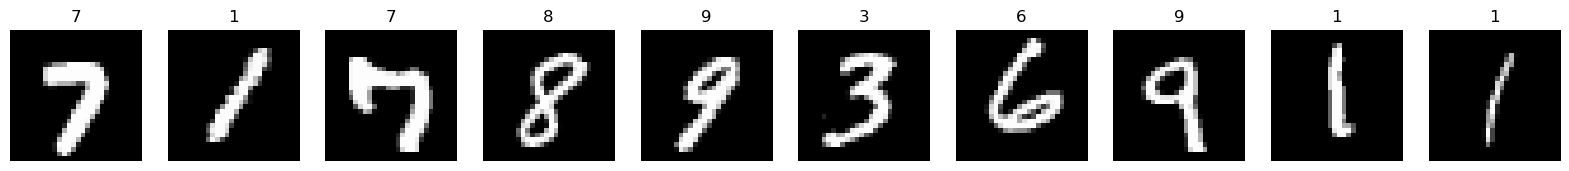

In [6]:
import torchvision
# Function should input the dataloader, and show random 10 images and their labels as title to plot

def show_imgs(imgs):
    # Create 10 subplots all in a row
    fig, ax = plt.subplots(1, 10, figsize=(20, 20))
    for i in range(10):
        # get some random training images

        dataiter = iter(train_loader)
        images, labels = next(dataiter)
        npimg = torchvision.utils.make_grid(images[0]).numpy()
        ax[i].axis('off')
        ax[i].imshow(np.transpose(npimg, (1, 2, 0)))
        ax[i].set_title(labels[0].item())

show_imgs(train_loader)

## 2. Utility Functions

Please complete `train()` and `plot_learning_curves()` functions. `test_accuracy()` has already been provided to you.

In [7]:
def test_accuracy(model, test_loader, input_size, loss_fn, device):
    model.to(device)
    correct = 0
    total = 0
    loss_valid, loss_train = [], []
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
            images = images.view(-1, input_size)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            valid_loss = loss_fn(outputs, labels)
            loss_valid.append(valid_loss.item())
    avg_valid_loss = sum(loss_valid) / len(loss_valid)
    #print('Accuracy: %d %%' % (100 * correct / total))
    return avg_valid_loss, (100 * correct / total)


### 2.1 Train Function
Please refer to the train function in `MNIST_Classifier.ipynb` to complete this function. You will need to store the loss and accuracies per iteration to plot. Please print the loss, accuracy and time taken for training each epoch.

In [105]:
import time

# Do I need 2D array to store information on epoc and corresponding train/validation arrays?

def train(model, loss_fn, optimizer, train_loader, batch_size, num_epochs, device):
    # Train Accuracy and Loss Arrays
    acc_arr_train = []
    loss_arr_train = []

    # Validation Accuracy and Loss Arrays
    acc_arr_valid = []
    loss_arr_valid = []

    # Rolling Average Vaidation/Train Arrays for every 100 iterations
    loss_avg_valid = []
    loss_avg_train = []
    w = 0
    # Iterate through all Epochs
    for epoch in range(num_epochs):
      # Iterate through training dataset
      start_epoc_time = time.perf_counter()
      for i, data in enumerate(train_loader, 0):
        # Flatten images and load images/labels
        images, labels = data[0].cuda(), data[1].cuda()
        images = images.view(-1, input_size)
        # Zero collected gradients at each step
        optimizer.zero_grad()
        # Forward Propagate
        outputs = model(images)

        # Calculate train Loss
        loss = loss_function(outputs, labels)

        # Back propagate
        loss.backward()
        # Update weights
        optimizer.step()

        # Store Loss of current iteration
        loss_arr_train.append(loss.item())

        # Print statistics on every 100th iteration
        if (i+1) % 100 == 0:
          # Average the past 100 iterations and append that Loss value
          avg_train = 0
          #for j in range(len(loss_arr_train) - 100 + 1):
          #  window_train = loss_arr_train[j:j + 100]
          #  avg_train = sum(window_train) / 100
          window_train = loss_arr_train[(w-99):(w+1)]
          avg_train =  sum(window_train) / 100
            
          avg_valid, _ = test_accuracy(model, test_loader, input_size, loss_function,  device)
          loss_avg_valid.append(avg_valid)
          loss_avg_train.append(avg_train) #TODO: Check to make sure it's only appended once per 100 iterations.

          print("""Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f, Val Loss: %.4f"""
                %(epoch+1, num_epochs, i+1,
                len(train_data) // batch_size, loss.item(), avg_valid)) 
        w = w + 1
      time_epoc_stop = time.perf_counter() # Stop the timer

      # Average of train and validation accuracies:
      _, train_acc = test_accuracy(model, train_loader, input_size, loss_function, None)
      _, test_acc = test_accuracy(model, test_loader, input_size, loss_function, None)

      acc_arr_train.append(train_acc)
      acc_arr_valid.append(test_acc)

      # Print epoc, time taken for epoc, train accuracy, valid accuracy
      print("""Epoch [%d/%d], Time Taken: %.4f, Train Acc: %.4f, Valid Acc: %.4f"""
            % (epoch + 1, num_epochs, time_epoc_stop - start_epoc_time,
             train_acc, test_acc))
      print("--------------------------------------------------------------")

    return acc_arr_train, acc_arr_valid, loss_avg_train, loss_avg_valid

### 2.2 Plot Learning Curves Function
Plot the loss and accuracies from training

In [106]:
def plot_learning_curve(train_loss, valid_loss, title):
    plt.figure(0)
    plt.plot(range(0, len(train_loss*100), 100), train_loss, label = "Train Loss")
    plt.plot(range(0, len(valid_loss*100), 100), valid_loss, label = "Validation Loss")
    plt.legend()
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

## 3) Define CNNs

A 1-Layer Architecture is already defined for you (`Net`) as a reference. Please complete the definitions of the 2-Layer CNN (`Net2`), 5-Layer CNN (`Net5`). The network architecture definitions are provided to you. You must calculate some dimensions yourself.

**NOTE:** For now, please use ReLU activation. You will experiment with other activations in Section 5.

In [107]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

### 3.1) 2-Layer CNN
Complete `Net2` class.

 Network Architecture:
* ***Layer 1 (Input)***: Convolutional; input channel = 1, output channel = 20, kernel size = 3, step size = 1.
* ***Layer 2 (Output)***: Fully connected; input dimension = < you find out >, output dimension = < you find out >.

In [108]:
# Define 2-Layer Network
class Net2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

## 4) Train and Evaluate

### 4.1) Here, you must test your utility functions (`train()` and `plot_learning_curves()`)with the 1-Layer Model. Please at this stage ensure your utility functions are working correctly.

**NOTE**: You can repeatedly use this below code black in Section 5 to run experiments, while making changes to the hyperparameters as requested.

In [109]:
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
acc_arr_train, acc_arr_valid, loss_avg_train, loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 0.1873, Val Loss: 0.2110
Epoch [1/5], Step [200/937], Train Loss: 0.2508, Val Loss: 0.2097
Epoch [1/5], Step [300/937], Train Loss: 0.3600, Val Loss: 0.1964
Epoch [1/5], Step [400/937], Train Loss: 0.1713, Val Loss: 0.1931
Epoch [1/5], Step [500/937], Train Loss: 0.1164, Val Loss: 0.1609
Epoch [1/5], Step [600/937], Train Loss: 0.1881, Val Loss: 0.1709
Epoch [1/5], Step [700/937], Train Loss: 0.4563, Val Loss: 0.1627
Epoch [1/5], Step [800/937], Train Loss: 0.0813, Val Loss: 0.1675
Epoch [1/5], Step [900/937], Train Loss: 0.0764, Val Loss: 0.1651
Epoch [1/5], Time Taken: 16.8036, Train Acc: 96.1117, Valid Acc: 95.3500
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.1303, Val Loss: 0.1493
Epoch [2/5], Step [200/937], Train Loss: 0.0686, Val Loss: 0.1363
Epoch [2/5], Step [300/937], Train Loss: 0.0758, Val Loss: 0.1405
Epoch [2/5], Step [400/937], Train Loss: 0.0784, Val Loss: 0.1638
Epoch 

(0.14470051573180115, 96.75)

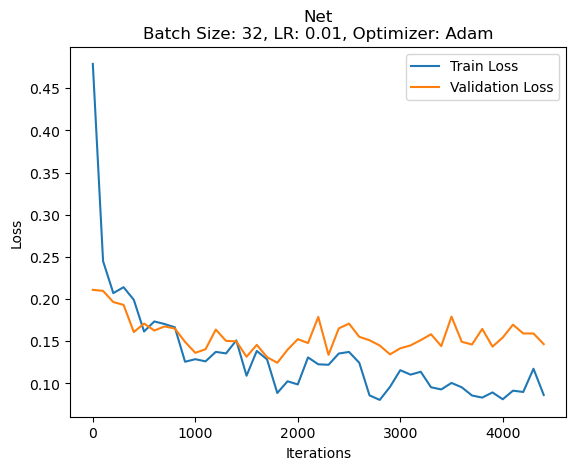

In [110]:
# Plot Learning Curves
plot_learning_curve(loss_avg_train, loss_avg_valid, "Net\nBatch Size: 32, LR: 0.01, Optimizer: Adam")

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, loss_fn=loss_function, device=device)

### 4.2) Please also train your 2-Layer network to ensure it is working properly.

In [28]:
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

#print(net)
# Train Model
Net2_acc_arr_train, Net2_acc_arr_valid, Net2_loss_avg_train, Net2_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.1049, Val Loss: 0.2293
Epoch [1/5], Step [200/1875], Train Loss: 0.1029, Val Loss: 0.1862
Epoch [1/5], Step [300/1875], Train Loss: 0.4339, Val Loss: 0.1687
Epoch [1/5], Step [400/1875], Train Loss: 0.3551, Val Loss: 0.1346
Epoch [1/5], Step [500/1875], Train Loss: 0.1962, Val Loss: 0.1598
Epoch [1/5], Step [600/1875], Train Loss: 0.3257, Val Loss: 0.1116
Epoch [1/5], Step [700/1875], Train Loss: 0.0789, Val Loss: 0.1067
Epoch [1/5], Step [800/1875], Train Loss: 0.0642, Val Loss: 0.1059
Epoch [1/5], Step [900/1875], Train Loss: 0.0507, Val Loss: 0.1059
Epoch [1/5], Step [1000/1875], Train Loss: 0.1072, Val Loss: 0.0956
Epoch [1/5], Step [1100/1875], Train Loss: 0.0592, Val Loss: 0.1037
Epoch [1/5], Step [1200/1875], Train Loss: 0.0130, Val Loss: 0.1033
Epoch [1/5], Step [1300/1875], Train Loss: 0.0945, Val Loss: 0.1162
Epoch [1/5], Step [1400/1875], Train Loss: 0.0712, Val Loss: 0.0993
Epoch [1/5], Step [1500/1875], Train Loss: 0.0529, Val Lo

(0.12556222188725416, 97.66)

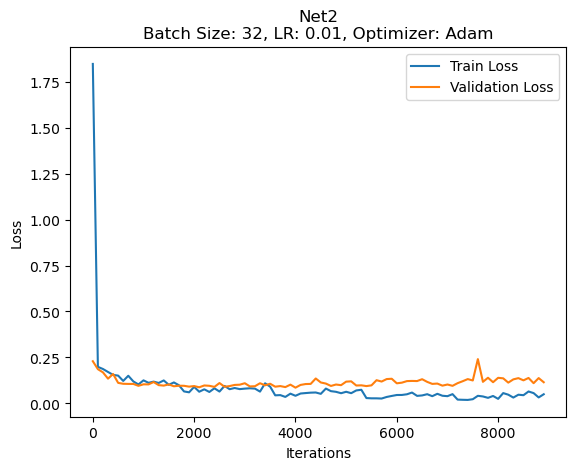

In [30]:
# Plot Learning Curves
plot_learning_curve(Net2_loss_avg_train, Net2_loss_avg_valid, "Net2\nBatch Size: 32, LR: 0.01, Optimizer: Adam")

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, loss_fn=loss_function, device=device)

## 5) Experiments and Reporting

In this section you will use your utility functioins and model definitons from before, and test for different scenarios. There are report questions you must answer for all sections below. Please use the loss, accuracy, and learning curves to help answer questions.

**NOTE:** In this section we will only change different parameters, so you can call most of your functions from previous sections. Any modifications needed in code asked by the questions in Section 5, please add them in the code sections indicated by `# YOUR CODE HERE`

### 5.1) Learning Curves

#### **Q 5.1) What is a Learning curve and why is it useful? You can refer to learning curves you have plotted in Section 4.**

---

A Learning curve measures the validation and training loss for each iteration. It is useful because it tells us whether the model is overfitting or underfitting.

### 5.2) Learning Rates

Please plot the curves for three separate training instances with learning rates of 2e-3, 3e-4, 5e-2. Use the 2-Layer CNN.

#### **Q 5.2) For each learning rate, explain if the model is underfitting, overfitting, or is training well. Explain the difference between high learning rates and low learning rates in terms of the optimization process.**

In [31]:
# Learning Rate 2e-3, "LR1"
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
LR1_acc_arr_train, LR1_acc_arr_valid, LR1_loss_avg_train, LR1_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.0774, Val Loss: 0.3621
Epoch [1/5], Step [200/1875], Train Loss: 0.0940, Val Loss: 0.3050
Epoch [1/5], Step [300/1875], Train Loss: 0.0795, Val Loss: 0.2263
Epoch [1/5], Step [400/1875], Train Loss: 0.0297, Val Loss: 0.1649
Epoch [1/5], Step [500/1875], Train Loss: 0.0286, Val Loss: 0.1558
Epoch [1/5], Step [600/1875], Train Loss: 0.0903, Val Loss: 0.1449
Epoch [1/5], Step [700/1875], Train Loss: 0.0838, Val Loss: 0.1213
Epoch [1/5], Step [800/1875], Train Loss: 0.0491, Val Loss: 0.1122
Epoch [1/5], Step [900/1875], Train Loss: 0.1007, Val Loss: 0.1139
Epoch [1/5], Step [1000/1875], Train Loss: 0.0991, Val Loss: 0.1154
Epoch [1/5], Step [1100/1875], Train Loss: 0.0488, Val Loss: 0.0928
Epoch [1/5], Step [1200/1875], Train Loss: 0.2702, Val Loss: 0.0940
Epoch [1/5], Step [1300/1875], Train Loss: 0.1100, Val Loss: 0.1044
Epoch [1/5], Step [1400/1875], Train Loss: 0.1400, Val Loss: 0.0929
Epoch [1/5], Step [1500/1875], Train Loss: 0.0282, Val Lo

In [32]:
# Learning Rate 3e-4, "LR2"
# Define Parameters
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
LR2_acc_arr_train, LR2_acc_arr_valid, LR2_loss_avg_train, LR2_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.8196, Val Loss: 0.5353
Epoch [1/5], Step [200/1875], Train Loss: 0.3553, Val Loss: 0.3908
Epoch [1/5], Step [300/1875], Train Loss: 0.2024, Val Loss: 0.3296
Epoch [1/5], Step [400/1875], Train Loss: 0.3189, Val Loss: 0.2931
Epoch [1/5], Step [500/1875], Train Loss: 0.2133, Val Loss: 0.2755
Epoch [1/5], Step [600/1875], Train Loss: 0.1643, Val Loss: 0.2681
Epoch [1/5], Step [700/1875], Train Loss: 0.1172, Val Loss: 0.2617
Epoch [1/5], Step [800/1875], Train Loss: 0.1023, Val Loss: 0.2351
Epoch [1/5], Step [900/1875], Train Loss: 0.1179, Val Loss: 0.2270
Epoch [1/5], Step [1000/1875], Train Loss: 0.5698, Val Loss: 0.2206
Epoch [1/5], Step [1100/1875], Train Loss: 0.1909, Val Loss: 0.2091
Epoch [1/5], Step [1200/1875], Train Loss: 0.2561, Val Loss: 0.1931
Epoch [1/5], Step [1300/1875], Train Loss: 0.7655, Val Loss: 0.1943
Epoch [1/5], Step [1400/1875], Train Loss: 0.1909, Val Loss: 0.1861
Epoch [1/5], Step [1500/1875], Train Loss: 0.1329, Val Lo

In [36]:
# Learning Rate 5e-2, "LR3"
# Define Parameters
input_size = 784
num_classes = 10
lr = 5e-2
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
LR3_acc_arr_train, LR3_acc_arr_valid, LR3_loss_avg_train, LR3_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.8700, Val Loss: 0.5282
Epoch [1/5], Step [200/1875], Train Loss: 0.1328, Val Loss: 0.4699
Epoch [1/5], Step [300/1875], Train Loss: 0.2703, Val Loss: 0.4469
Epoch [1/5], Step [400/1875], Train Loss: 0.6102, Val Loss: 0.3943
Epoch [1/5], Step [500/1875], Train Loss: 0.3516, Val Loss: 0.4251
Epoch [1/5], Step [600/1875], Train Loss: 0.2863, Val Loss: 0.3911
Epoch [1/5], Step [700/1875], Train Loss: 0.4349, Val Loss: 0.3840
Epoch [1/5], Step [800/1875], Train Loss: 0.4131, Val Loss: 0.5621
Epoch [1/5], Step [900/1875], Train Loss: 0.4089, Val Loss: 0.4026
Epoch [1/5], Step [1000/1875], Train Loss: 0.2037, Val Loss: 0.3888
Epoch [1/5], Step [1100/1875], Train Loss: 0.9126, Val Loss: 0.4438
Epoch [1/5], Step [1200/1875], Train Loss: 0.4796, Val Loss: 0.3618
Epoch [1/5], Step [1300/1875], Train Loss: 0.8315, Val Loss: 0.3471
Epoch [1/5], Step [1400/1875], Train Loss: 0.2863, Val Loss: 0.4352
Epoch [1/5], Step [1500/1875], Train Loss: 0.4632, Val Lo

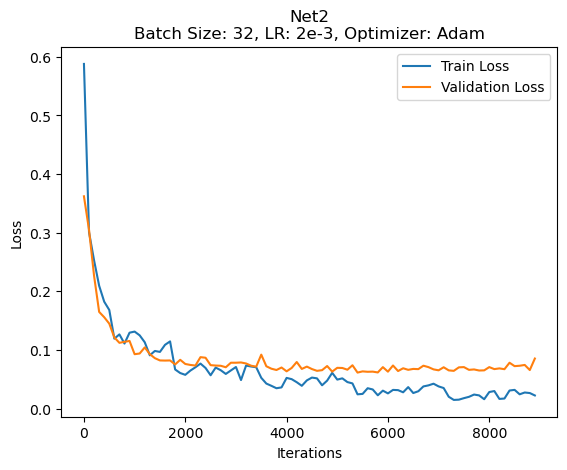

In [41]:
# Plot the curves:

# TODO: Label the plot titles
plot_learning_curve(LR1_loss_avg_train, LR1_loss_avg_valid, "Net2\nBatch Size: 32, LR: 2e-3, Optimizer: Adam")

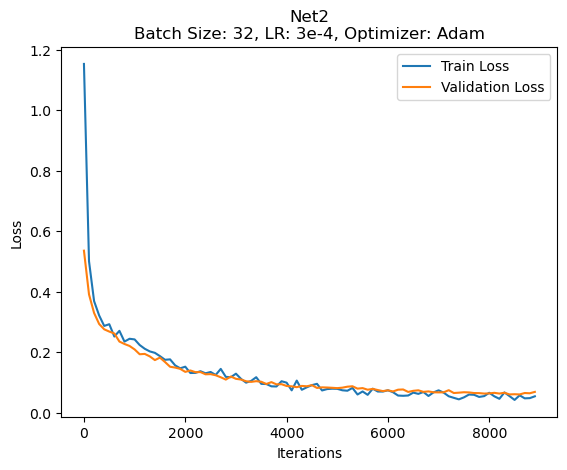

In [38]:
plot_learning_curve(LR2_loss_avg_train, LR2_loss_avg_valid, "Net2\nBatch Size: 32, LR: 3e-4, Optimizer: Adam")

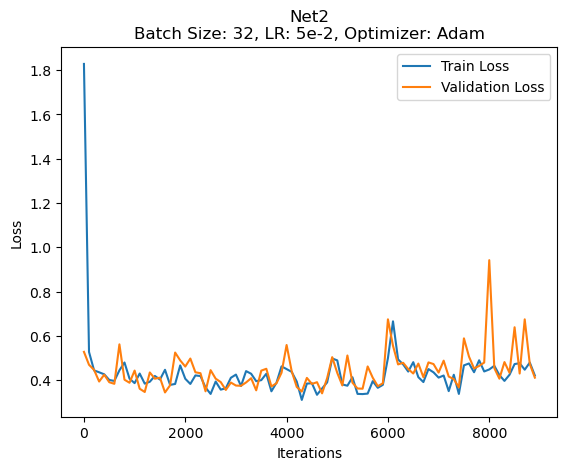

In [39]:
plot_learning_curve(LR3_loss_avg_train, LR3_loss_avg_valid, "Net2\nBatch Size: 32, LR: 5e-2, Optimizer: Adam")

---

### 5.3) Optimizer
The optimizer we have used before is Adam. Change the optimizer to use stochastic gradient descent (SGD), and SGD with momentum. Use 2-Layer CNN.

#### **Q 5.3) Explain the differences in Adam and both SGD optimizations. Compare the results of each optimizer based on the learning curves.**

Adam uses a changing learning rate throughout optimization while the SGD implementations both use a fixed learning rate. SGD with momentum takes into account previous gradient information for each step in an attempt to not get stuck in local minimum. Adam usually converges faster due to its changing learning rate.

In [42]:
# Optimizer SGD
# Learning Rate 0.002
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# Train Model
SGD_acc_arr_train, SGD_acc_arr_valid, SGD_loss_avg_train, SGD_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.9254, Val Loss: 0.7198
Epoch [1/5], Step [200/1875], Train Loss: 0.2206, Val Loss: 0.4569
Epoch [1/5], Step [300/1875], Train Loss: 0.3959, Val Loss: 0.3934
Epoch [1/5], Step [400/1875], Train Loss: 0.3765, Val Loss: 0.3850
Epoch [1/5], Step [500/1875], Train Loss: 0.1654, Val Loss: 0.3564
Epoch [1/5], Step [600/1875], Train Loss: 0.5020, Val Loss: 0.3287
Epoch [1/5], Step [700/1875], Train Loss: 0.5310, Val Loss: 0.3274
Epoch [1/5], Step [800/1875], Train Loss: 0.4859, Val Loss: 0.3388
Epoch [1/5], Step [900/1875], Train Loss: 0.6611, Val Loss: 0.3169
Epoch [1/5], Step [1000/1875], Train Loss: 0.3008, Val Loss: 0.3318
Epoch [1/5], Step [1100/1875], Train Loss: 0.2796, Val Loss: 0.3040
Epoch [1/5], Step [1200/1875], Train Loss: 0.3638, Val Loss: 0.3119
Epoch [1/5], Step [1300/1875], Train Loss: 0.2373, Val Loss: 0.2965
Epoch [1/5], Step [1400/1875], Train Loss: 0.2219, Val Loss: 0.2990
Epoch [1/5], Step [1500/1875], Train Loss: 0.2536, Val Lo

In [43]:
# Optimizer SGD (Momentum = 0.9), SGDM
# Learning Rate 0.002
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
SGDM_acc_arr_train, SGDM_acc_arr_valid, SGDM_loss_avg_train, SGDM_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.4108, Val Loss: 0.4127
Epoch [1/5], Step [200/1875], Train Loss: 0.3356, Val Loss: 0.3586
Epoch [1/5], Step [300/1875], Train Loss: 0.6065, Val Loss: 0.3071
Epoch [1/5], Step [400/1875], Train Loss: 0.2844, Val Loss: 0.2583
Epoch [1/5], Step [500/1875], Train Loss: 0.2845, Val Loss: 0.2260
Epoch [1/5], Step [600/1875], Train Loss: 0.1920, Val Loss: 0.2118
Epoch [1/5], Step [700/1875], Train Loss: 0.1424, Val Loss: 0.1794
Epoch [1/5], Step [800/1875], Train Loss: 0.1680, Val Loss: 0.1617
Epoch [1/5], Step [900/1875], Train Loss: 0.2653, Val Loss: 0.1432
Epoch [1/5], Step [1000/1875], Train Loss: 0.0331, Val Loss: 0.1327
Epoch [1/5], Step [1100/1875], Train Loss: 0.0630, Val Loss: 0.1506
Epoch [1/5], Step [1200/1875], Train Loss: 0.1301, Val Loss: 0.1221
Epoch [1/5], Step [1300/1875], Train Loss: 0.2610, Val Loss: 0.1177
Epoch [1/5], Step [1400/1875], Train Loss: 0.1037, Val Loss: 0.1183
Epoch [1/5], Step [1500/1875], Train Loss: 0.0847, Val Lo

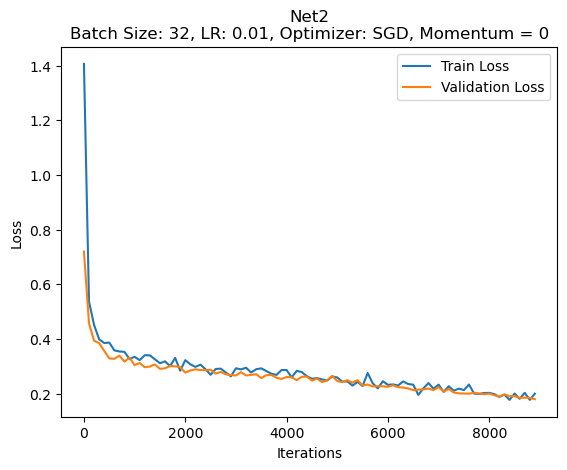

In [48]:
plot_learning_curve(SGD_loss_avg_train, SGD_loss_avg_valid, "Net2\nBatch Size: 32, LR: 0.01, Optimizer: SGD, Momentum = 0")

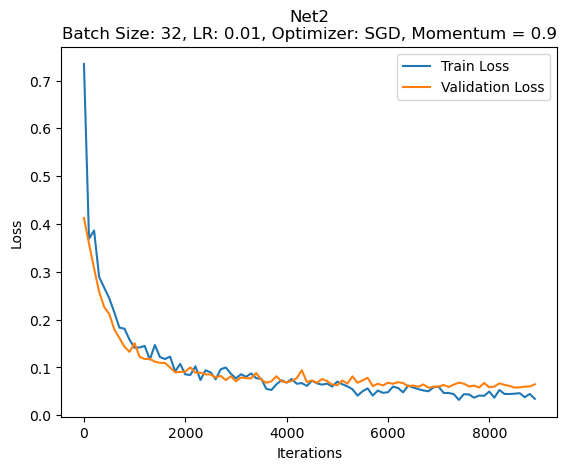

In [49]:
plot_learning_curve(SGDM_loss_avg_train, SGDM_loss_avg_valid, "Net2\nBatch Size: 32, LR: 0.01, Optimizer: SGD, Momentum = 0.9")

---

### 5.4) Initializing Weights

Initialize the weights to all zeros, all ones and all randomly initialized with a normal distribution. Use 2-Layer CNN.

#### **Q 5.4) How is the training process affected when we initialize our network weights differently? Based on what you observe, give a recommendation as to how weights should be initialized. Explain your reasoning.**

Doing random initialization is best because set values have the problem of having similar gradients initially which can lead to the model getting stuck in a local minimum.

In [50]:
# Define 2-Layer Network
class Net2_0(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_0, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.conv1.weight.data.fill_(0)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26
        self.fc2.weight.data.fill_(0)

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [51]:
# Define 2-Layer Network
class Net2_1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.conv1.weight.data.fill_(1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26
        self.fc2.weight.data.fill_(1)

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [52]:
# Define 2-Layer Network
class Net2_rand(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_rand, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight, gain=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26
        torch.nn.init.xavier_uniform_(self.fc2.weight, gain=1)


    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [53]:
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_0(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN0_acc_arr_train, CNN0_acc_arr_valid, CNN0_loss_avg_train, CNN0_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.5625, Val Loss: 0.6163
Epoch [1/5], Step [200/1875], Train Loss: 0.5872, Val Loss: 0.4748
Epoch [1/5], Step [300/1875], Train Loss: 0.5475, Val Loss: 0.5657
Epoch [1/5], Step [400/1875], Train Loss: 0.5939, Val Loss: 0.3875
Epoch [1/5], Step [500/1875], Train Loss: 0.8938, Val Loss: 0.3564
Epoch [1/5], Step [600/1875], Train Loss: 0.3435, Val Loss: 0.4050
Epoch [1/5], Step [700/1875], Train Loss: 0.3519, Val Loss: 0.3772
Epoch [1/5], Step [800/1875], Train Loss: 0.1548, Val Loss: 0.3684
Epoch [1/5], Step [900/1875], Train Loss: 0.1828, Val Loss: 0.3795
Epoch [1/5], Step [1000/1875], Train Loss: 0.3109, Val Loss: 0.3018
Epoch [1/5], Step [1100/1875], Train Loss: 0.1185, Val Loss: 0.2993
Epoch [1/5], Step [1200/1875], Train Loss: 0.2565, Val Loss: 0.2141
Epoch [1/5], Step [1300/1875], Train Loss: 0.1014, Val Loss: 0.2192
Epoch [1/5], Step [1400/1875], Train Loss: 0.1648, Val Loss: 0.1687
Epoch [1/5], Step [1500/1875], Train Loss: 0.0396, Val Lo

In [54]:
# Initialize all weights to 1
# Learning Rate 5e-2
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_1(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN1_acc_arr_train, CNN1_acc_arr_valid, CNN1_loss_avg_train, CNN1_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.8399, Val Loss: 4.2963
Epoch [1/5], Step [200/1875], Train Loss: 0.2722, Val Loss: 0.3969
Epoch [1/5], Step [300/1875], Train Loss: 0.5786, Val Loss: 0.3735
Epoch [1/5], Step [400/1875], Train Loss: 0.4312, Val Loss: 0.3513
Epoch [1/5], Step [500/1875], Train Loss: 0.2881, Val Loss: 0.3174
Epoch [1/5], Step [600/1875], Train Loss: 0.4256, Val Loss: 0.3422
Epoch [1/5], Step [700/1875], Train Loss: 0.2740, Val Loss: 0.3255
Epoch [1/5], Step [800/1875], Train Loss: 0.2310, Val Loss: 0.3322
Epoch [1/5], Step [900/1875], Train Loss: 0.3307, Val Loss: 0.3190
Epoch [1/5], Step [1000/1875], Train Loss: 0.0626, Val Loss: 0.3089
Epoch [1/5], Step [1100/1875], Train Loss: 0.9604, Val Loss: 0.3257
Epoch [1/5], Step [1200/1875], Train Loss: 0.3379, Val Loss: 0.3373
Epoch [1/5], Step [1300/1875], Train Loss: 0.1195, Val Loss: 0.2877
Epoch [1/5], Step [1400/1875], Train Loss: 0.6726, Val Loss: 0.2823
Epoch [1/5], Step [1500/1875], Train Loss: 0.2765, Val Lo

In [55]:
# Random weight initialization on Net2
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_rand(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNNrand_acc_arr_train, CNNrand_acc_arr_valid, CNNrand_loss_avg_train, CNNrand_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.4920, Val Loss: 0.2309
Epoch [1/5], Step [200/1875], Train Loss: 0.2097, Val Loss: 0.1705
Epoch [1/5], Step [300/1875], Train Loss: 0.0379, Val Loss: 0.1547
Epoch [1/5], Step [400/1875], Train Loss: 0.3852, Val Loss: 0.1591
Epoch [1/5], Step [500/1875], Train Loss: 0.1727, Val Loss: 0.1249
Epoch [1/5], Step [600/1875], Train Loss: 0.2582, Val Loss: 0.1460
Epoch [1/5], Step [700/1875], Train Loss: 0.5667, Val Loss: 0.1102
Epoch [1/5], Step [800/1875], Train Loss: 0.2821, Val Loss: 0.1069
Epoch [1/5], Step [900/1875], Train Loss: 0.1012, Val Loss: 0.1164
Epoch [1/5], Step [1000/1875], Train Loss: 0.1839, Val Loss: 0.0944
Epoch [1/5], Step [1100/1875], Train Loss: 0.0893, Val Loss: 0.1056
Epoch [1/5], Step [1200/1875], Train Loss: 0.0985, Val Loss: 0.1060
Epoch [1/5], Step [1300/1875], Train Loss: 0.2178, Val Loss: 0.1048
Epoch [1/5], Step [1400/1875], Train Loss: 0.0411, Val Loss: 0.0941
Epoch [1/5], Step [1500/1875], Train Loss: 0.2293, Val Lo

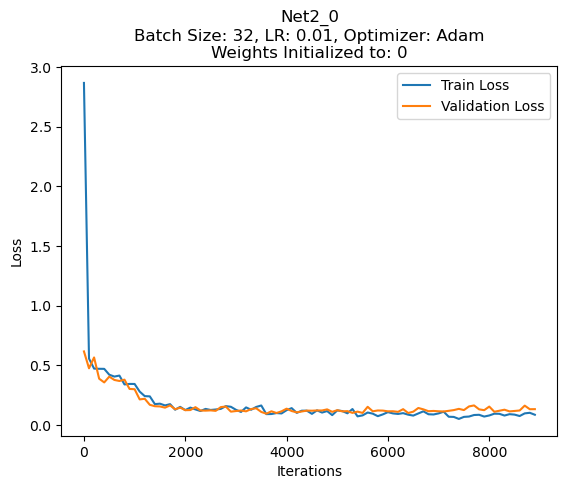

In [62]:
plot_learning_curve(CNN0_loss_avg_train, CNN0_loss_avg_valid, "Net2_0\nBatch Size: 32, LR: 0.01, Optimizer: Adam\nWeights Initialized to: 0")

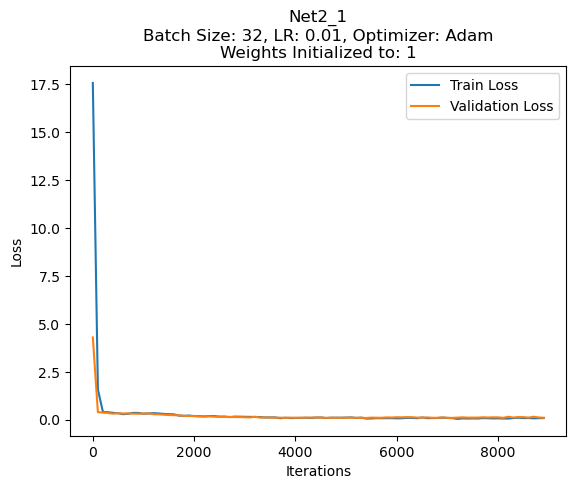

In [63]:
plot_learning_curve(CNN1_loss_avg_train, CNN1_loss_avg_valid, "Net2_1\nBatch Size: 32, LR: 0.01, Optimizer: Adam\nWeights Initialized to: 1")

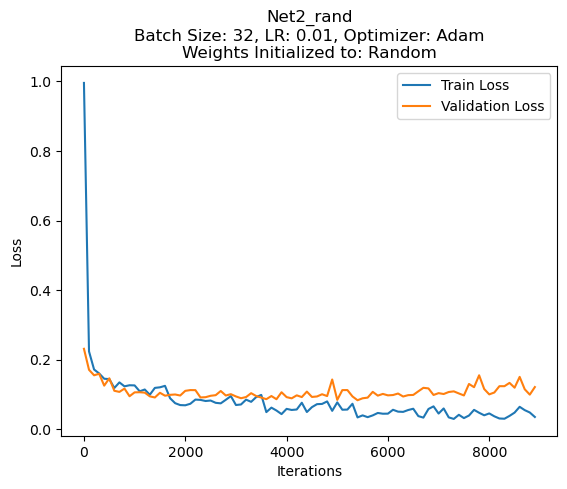

In [64]:
plot_learning_curve(CNNrand_loss_avg_train, CNNrand_loss_avg_valid, "Net2_rand\nBatch Size: 32, LR: 0.01, Optimizer: Adam\nWeights Initialized to: Random")

---

### 5.5) Activation Function

Please change the relu function in the example code to a tanh function. Use 2-Layer CNN.

#### **Q 5.5) How does changing the activation function to tanh affect the performance. Is it better or worse? Explain why.**

Changing the function to tanh decreased the performance because it causes slower convergence due to having lower value gradients for positive values which is what we have in the image input.

In [59]:
# Define 2-Layer Network
class Net2_tanh(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_tanh, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.tanh(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [60]:
# Random weight initialization on Net2
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_tanh(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNNtanh_acc_arr_train, CNNtanh_acc_arr_valid, CNNtanh_loss_avg_train, CNNtanh_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.4886, Val Loss: 0.6445
Epoch [1/5], Step [200/1875], Train Loss: 0.4078, Val Loss: 0.4260
Epoch [1/5], Step [300/1875], Train Loss: 0.8358, Val Loss: 0.3936
Epoch [1/5], Step [400/1875], Train Loss: 0.2873, Val Loss: 0.3572
Epoch [1/5], Step [500/1875], Train Loss: 0.2003, Val Loss: 0.3606
Epoch [1/5], Step [600/1875], Train Loss: 0.2773, Val Loss: 0.3968
Epoch [1/5], Step [700/1875], Train Loss: 0.1884, Val Loss: 0.3481
Epoch [1/5], Step [800/1875], Train Loss: 0.4576, Val Loss: 0.3668
Epoch [1/5], Step [900/1875], Train Loss: 0.3732, Val Loss: 0.3571
Epoch [1/5], Step [1000/1875], Train Loss: 0.2537, Val Loss: 0.3490
Epoch [1/5], Step [1100/1875], Train Loss: 0.6930, Val Loss: 0.4523
Epoch [1/5], Step [1200/1875], Train Loss: 0.1406, Val Loss: 0.4325
Epoch [1/5], Step [1300/1875], Train Loss: 0.4730, Val Loss: 0.6827
Epoch [1/5], Step [1400/1875], Train Loss: 0.3473, Val Loss: 0.4150
Epoch [1/5], Step [1500/1875], Train Loss: 0.2051, Val Lo

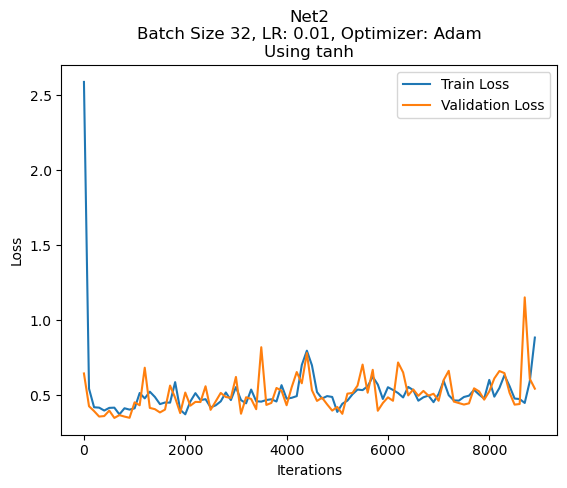

In [65]:
plot_learning_curve(CNNtanh_loss_avg_train, CNNtanh_loss_avg_valid, "Net2\nBatch Size 32, LR: 0.01, Optimizer: Adam\nUsing tanh")

---

### 5.6) Batch Size

Please use batch size of 128, 256, 512. Use 2-Layer CNN.

#### **Q 5.6) How does changing batch size affect the training process?**

Having larger batch sizes can lead to better generalization as the gradients are updated based on a larger amount of data which prevents outliers from having a large impact. It will take longer however since more memory needs to be allocated on the GPU for a larger batch to be processed. It could require more epochs to be done to converge as the gradients are updated less often so less steps are taken in the direction of the gradient which causes slower convergence.

In [66]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [67]:
# Random weight initialization on Net2
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN_1_acc_arr_train, CNN_1_acc_arr_valid, CNN_1_loss_avg_train, CNN_1_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/468], Train Loss: 0.2275, Val Loss: 0.1722
Epoch [1/5], Step [200/468], Train Loss: 0.1394, Val Loss: 0.1186
Epoch [1/5], Step [300/468], Train Loss: 0.1378, Val Loss: 0.1035
Epoch [1/5], Step [400/468], Train Loss: 0.0952, Val Loss: 0.0943
Epoch [1/5], Time Taken: 10.7380, Train Acc: 98.0917, Valid Acc: 97.4700
--------------------------------------------------------------
Epoch [2/5], Step [100/468], Train Loss: 0.0655, Val Loss: 0.0929
Epoch [2/5], Step [200/468], Train Loss: 0.0763, Val Loss: 0.0788
Epoch [2/5], Step [300/468], Train Loss: 0.0573, Val Loss: 0.0775
Epoch [2/5], Step [400/468], Train Loss: 0.1037, Val Loss: 0.0763
Epoch [2/5], Time Taken: 10.9437, Train Acc: 98.7100, Valid Acc: 97.5800
--------------------------------------------------------------
Epoch [3/5], Step [100/468], Train Loss: 0.0466, Val Loss: 0.0674
Epoch [3/5], Step [200/468], Train Loss: 0.0186, Val Loss: 0.0809
Epoch [3/5], Step [300/468], Train Loss: 0.0617, Val Loss: 0.0694
Ep

In [68]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [69]:
# Random weight initialization on Net2
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN_2_acc_arr_train, CNN_2_acc_arr_valid, CNN_2_loss_avg_train, CNN_2_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/234], Train Loss: 0.2454, Val Loss: 0.1467
Epoch [1/5], Step [200/234], Train Loss: 0.0928, Val Loss: 0.1013
Epoch [1/5], Time Taken: 8.2586, Train Acc: 97.7517, Valid Acc: 97.3100
--------------------------------------------------------------
Epoch [2/5], Step [100/234], Train Loss: 0.0598, Val Loss: 0.0792
Epoch [2/5], Step [200/234], Train Loss: 0.0998, Val Loss: 0.0826
Epoch [2/5], Time Taken: 8.1311, Train Acc: 98.4483, Valid Acc: 97.6700
--------------------------------------------------------------
Epoch [3/5], Step [100/234], Train Loss: 0.1048, Val Loss: 0.0711
Epoch [3/5], Step [200/234], Train Loss: 0.0631, Val Loss: 0.0735
Epoch [3/5], Time Taken: 8.1070, Train Acc: 98.9600, Valid Acc: 97.7900
--------------------------------------------------------------
Epoch [4/5], Step [100/234], Train Loss: 0.0270, Val Loss: 0.0710
Epoch [4/5], Step [200/234], Train Loss: 0.0561, Val Loss: 0.0656
Epoch [4/5], Time Taken: 8.0495, Train Acc: 99.1217, Valid Acc: 97.

In [70]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [71]:
# Random weight initialization on Net2
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN_3_acc_arr_train, CNN_3_acc_arr_valid, CNN_3_loss_avg_train, CNN_3_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/117], Train Loss: 0.1360, Val Loss: 0.1380
Epoch [1/5], Time Taken: 6.8542, Train Acc: 96.8433, Valid Acc: 96.5500
--------------------------------------------------------------
Epoch [2/5], Step [100/117], Train Loss: 0.0892, Val Loss: 0.0894
Epoch [2/5], Time Taken: 6.8818, Train Acc: 97.9133, Valid Acc: 97.1800
--------------------------------------------------------------
Epoch [3/5], Step [100/117], Train Loss: 0.0620, Val Loss: 0.0761
Epoch [3/5], Time Taken: 6.9511, Train Acc: 98.4617, Valid Acc: 97.5600
--------------------------------------------------------------
Epoch [4/5], Step [100/117], Train Loss: 0.0524, Val Loss: 0.0823
Epoch [4/5], Time Taken: 7.1870, Train Acc: 98.8767, Valid Acc: 97.6900
--------------------------------------------------------------
Epoch [5/5], Step [100/117], Train Loss: 0.0421, Val Loss: 0.0749
Epoch [5/5], Time Taken: 6.8507, Train Acc: 99.0733, Valid Acc: 97.6200
----------------------------------------------------------

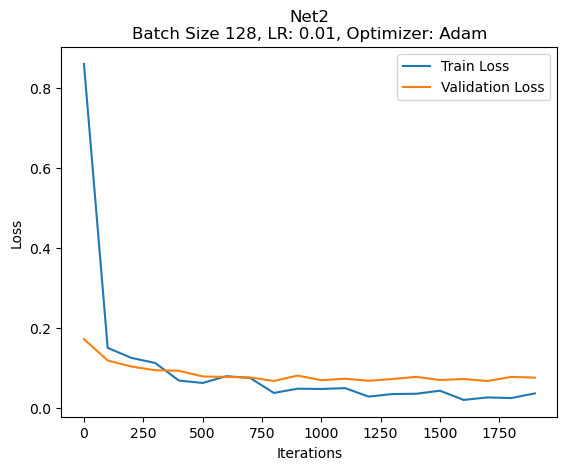

In [72]:
plot_learning_curve(CNN_1_loss_avg_train, CNN_1_loss_avg_valid, "Net2\nBatch Size 128, LR: 0.01, Optimizer: Adam")

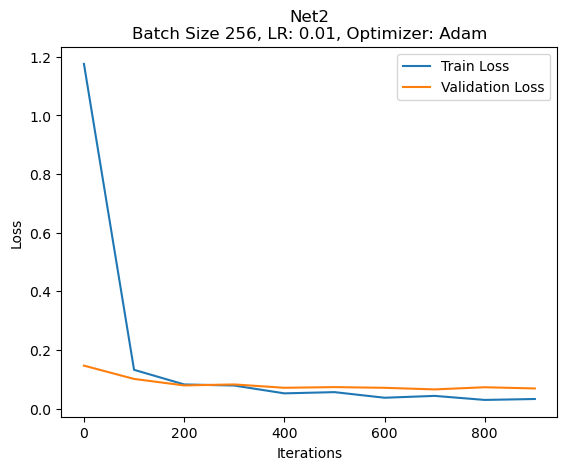

In [73]:
plot_learning_curve(CNN_2_loss_avg_train, CNN_2_loss_avg_valid, "Net2\nBatch Size 256, LR: 0.01, Optimizer: Adam")

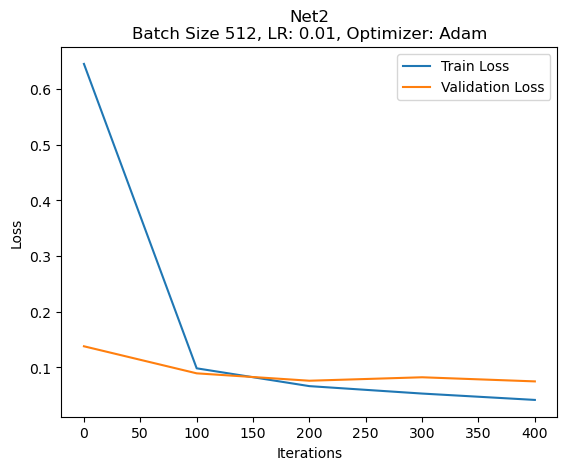

In [74]:
plot_learning_curve(CNN_3_loss_avg_train, CNN_3_loss_avg_valid, "Net2\nBatch Size 512, LR: 0.01, Optimizer: Adam")

---

### 5.7) Different Network Architectures

Please complete the `Net5` and `FCN` definitions. The archtiectures are defined below.

Train `Net`, `Net2`, `Net5`, and `FCN` using batch size of 64, the best learning rate from Section 5.1, and the best optimizer froom Section 5.5

#### **Q 5.7.1) Explain which model is better and why. Use your learning curves as well as what you know about model capacity to explain your reasoning.**

#### **Q 5.7.2) Which model converges to a minimum faster? Why? What hyperparameters would you tune in order to get a model to converge faster?**

#### **Q 5.7.3) Explain the purpose of the pooling layer**

#### **Q 5.7.4)  Is it possible for a model to have a smaller final loss, even if it has worse test accuracy.**

#### **Q 5.7.5) Explain the difference between the CNN models and FCN.**

5.7.1 The Net model is better because it a shallower network. The Net5 model overfits because it is a deeper network, which leads to a lower accuracy compared to the Net. The same logic can be applied for the Net2, which is close in accuracy to the Net. The Net has a higher accuracy than the FCN most likely because FCNs are best when used for pixel-level predictions and highly detailed spatial localization. CNNs shine in single output predictions in relation to the entire image.

5.7.2 Net5 converges to a minimum faster. This makes sense due to its higher complexity and thus can be seen overfitting the data. As a result, it converges to the minimum much quicker. To have a model converge faster, we would increase the learning rate, and lowering the batch size so that less steps are taken per epoch.

5.7.3 : The purpose of the pooling layer is to reduce the dimensions of the input volume, decreasing the amount of parameters in the neural network, which ultimately lends way to a reduction of overfitting

5.7.4: Yes, it's possible for a model to have a smaller final loss with a worse test accuracy. This may occur if the model is overfitted, and struggles to generalize. The finals loss is lower as it indicates a good fit.

5.7.5 The CNN model uses layers and is better fitted for single output prediction tasks that take into account the entire image. The FCN model identifies the objects in the individual pixels of an image, and thus is better fitted when used for pixel-level predicitions and more highly detailed spatial localization tasks.



In [88]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [89]:

# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = Net(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
Net_64_acc_arr_train, Net_64_acc_arr_valid, Net_64_loss_avg_train, Net_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 2.2484, Val Loss: 2.2540
Epoch [1/5], Step [200/937], Train Loss: 2.1931, Val Loss: 2.1857
Epoch [1/5], Step [300/937], Train Loss: 2.0998, Val Loss: 2.1131
Epoch [1/5], Step [400/937], Train Loss: 2.0641, Val Loss: 2.0325
Epoch [1/5], Step [500/937], Train Loss: 1.9383, Val Loss: 1.9433
Epoch [1/5], Step [600/937], Train Loss: 1.8680, Val Loss: 1.8461
Epoch [1/5], Step [700/937], Train Loss: 1.7348, Val Loss: 1.7418
Epoch [1/5], Step [800/937], Train Loss: 1.6788, Val Loss: 1.6341
Epoch [1/5], Step [900/937], Train Loss: 1.5469, Val Loss: 1.5260
Epoch [1/5], Time Taken: 17.0017, Train Acc: 76.3500, Valid Acc: 76.9300
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 1.4134, Val Loss: 1.3847
Epoch [2/5], Step [200/937], Train Loss: 1.2534, Val Loss: 1.2893
Epoch [2/5], Step [300/937], Train Loss: 1.2998, Val Loss: 1.2009
Epoch [2/5], Step [400/937], Train Loss: 1.1757, Val Loss: 1.1219
Epoch 

In [90]:
# Net2
# Learning Rate 2e-3, "LR1"
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
Net2_64_acc_arr_train, Net2_64_acc_arr_valid, Net2_64_loss_avg_train, Net2_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 1.5157, Val Loss: 1.5015
Epoch [1/5], Step [200/937], Train Loss: 1.0992, Val Loss: 0.8996
Epoch [1/5], Step [300/937], Train Loss: 0.8961, Val Loss: 0.6539
Epoch [1/5], Step [400/937], Train Loss: 0.4950, Val Loss: 0.5418
Epoch [1/5], Step [500/937], Train Loss: 0.4202, Val Loss: 0.4780
Epoch [1/5], Step [600/937], Train Loss: 0.4007, Val Loss: 0.4410
Epoch [1/5], Step [700/937], Train Loss: 0.2342, Val Loss: 0.4141
Epoch [1/5], Step [800/937], Train Loss: 0.6654, Val Loss: 0.3962
Epoch [1/5], Step [900/937], Train Loss: 0.4987, Val Loss: 0.3817
Epoch [1/5], Time Taken: 17.2176, Train Acc: 88.8250, Valid Acc: 89.4400
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.3963, Val Loss: 0.3689
Epoch [2/5], Step [200/937], Train Loss: 0.5442, Val Loss: 0.3577
Epoch [2/5], Step [300/937], Train Loss: 0.3080, Val Loss: 0.3498
Epoch [2/5], Step [400/937], Train Loss: 0.2897, Val Loss: 0.3455
Epoch 

In [91]:
# Net5
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = Net5(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
Net5_64_acc_arr_train, Net5_64_acc_arr_valid, Net5_64_loss_avg_train, Net5_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 2.2278, Val Loss: 2.2252
Epoch [1/5], Step [200/937], Train Loss: 2.0466, Val Loss: 2.0614
Epoch [1/5], Step [300/937], Train Loss: 1.7089, Val Loss: 1.6899
Epoch [1/5], Step [400/937], Train Loss: 1.1201, Val Loss: 1.0950
Epoch [1/5], Step [500/937], Train Loss: 0.7232, Val Loss: 0.7206
Epoch [1/5], Step [600/937], Train Loss: 0.6251, Val Loss: 0.5646
Epoch [1/5], Step [700/937], Train Loss: 0.6346, Val Loss: 0.4887
Epoch [1/5], Step [800/937], Train Loss: 0.6568, Val Loss: 0.4456
Epoch [1/5], Step [900/937], Train Loss: 0.3670, Val Loss: 0.4154
Epoch [1/5], Time Taken: 19.3126, Train Acc: 87.8100, Valid Acc: 88.6100
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.3149, Val Loss: 0.3903
Epoch [2/5], Step [200/937], Train Loss: 0.4098, Val Loss: 0.3792
Epoch [2/5], Step [300/937], Train Loss: 0.3259, Val Loss: 0.3655
Epoch [2/5], Step [400/937], Train Loss: 0.3607, Val Loss: 0.3593
Epoch 

In [92]:
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = FCN(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
FCN_64_acc_arr_train, FCN_64_acc_arr_valid, FCN_64_loss_avg_train, FCN_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 2.2923, Val Loss: 2.2910
Epoch [1/5], Step [200/937], Train Loss: 2.2874, Val Loss: 2.2804
Epoch [1/5], Step [300/937], Train Loss: 2.2657, Val Loss: 2.2690
Epoch [1/5], Step [400/937], Train Loss: 2.2596, Val Loss: 2.2567
Epoch [1/5], Step [500/937], Train Loss: 2.2352, Val Loss: 2.2426
Epoch [1/5], Step [600/937], Train Loss: 2.2427, Val Loss: 2.2263
Epoch [1/5], Step [700/937], Train Loss: 2.1988, Val Loss: 2.2076
Epoch [1/5], Step [800/937], Train Loss: 2.1912, Val Loss: 2.1850
Epoch [1/5], Step [900/937], Train Loss: 2.1658, Val Loss: 2.1577
Epoch [1/5], Time Taken: 16.5027, Train Acc: 60.2167, Valid Acc: 60.4300
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 2.1622, Val Loss: 2.1114
Epoch [2/5], Step [200/937], Train Loss: 2.0929, Val Loss: 2.0700
Epoch [2/5], Step [300/937], Train Loss: 2.0116, Val Loss: 2.0205
Epoch [2/5], Step [400/937], Train Loss: 2.0230, Val Loss: 1.9616
Epoch 

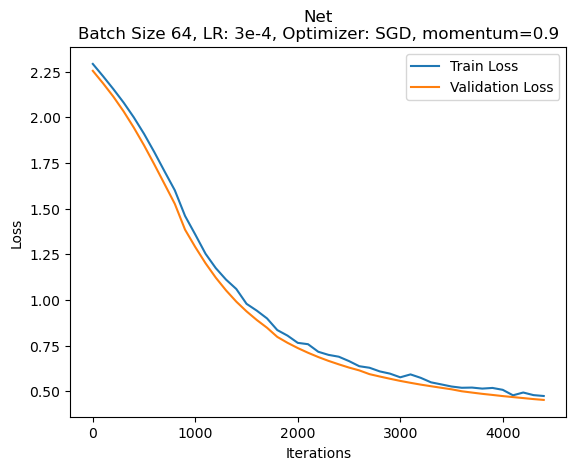

In [93]:
plot_learning_curve(Net_64_loss_avg_train, Net_64_loss_avg_valid, "Net\nBatch Size 64, LR: 3e-4, Optimizer: SGD, momentum=0.9")

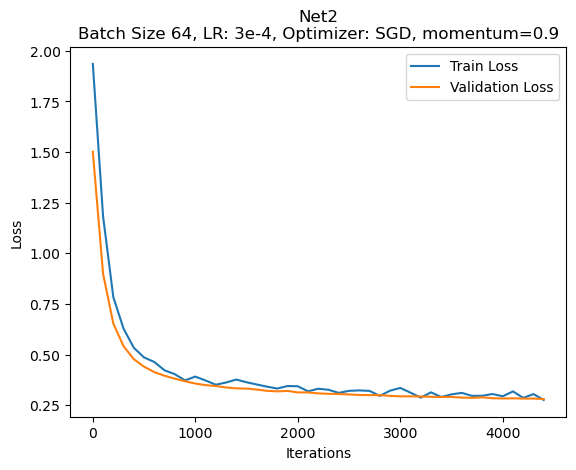

In [94]:
plot_learning_curve(Net2_64_loss_avg_train, Net2_64_loss_avg_valid, "Net2\nBatch Size 64, LR: 3e-4, Optimizer: SGD, momentum=0.9")

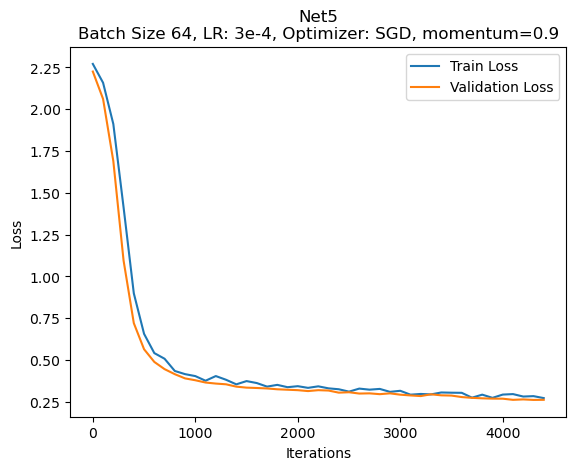

In [95]:
plot_learning_curve(Net5_64_loss_avg_train, Net5_64_loss_avg_valid, "Net5\nBatch Size 64, LR: 3e-4, Optimizer: SGD, momentum=0.9")

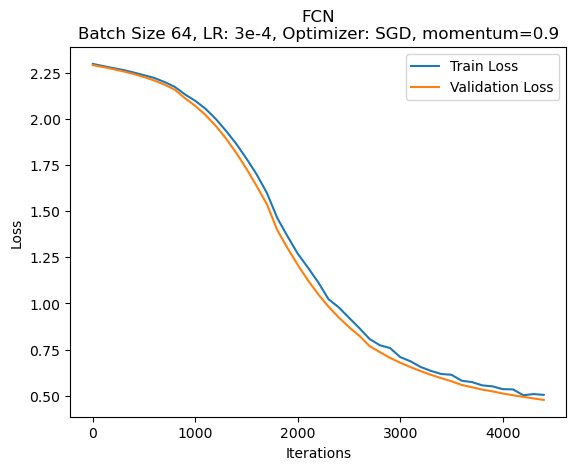

In [96]:
plot_learning_curve(FCN_64_loss_avg_train, FCN_64_loss_avg_valid, "FCN\nBatch Size 64, LR: 3e-4, Optimizer: SGD, momentum=0.9")

#### 5-Layer CNN
Similar to the 2-Layer model, make a new class ```Net5```

* ***Layer 1 (Input)***: Convolutional, input channel = 1, output channel = 32, kernel size = 5, stride = 1, padding = 2.
* ***Layer 2 (Hidden 1)***: Pooling, kernel size = 2, stride = 2.
* ***Layer 3 (Hidden 2)***: Convolutional, input channel = < you find out> , output channel = 64, kernel size = 5, stride = 1 padding = 2.
* ***Layer 4 (Hidden 3)***: Fully connected, input channel = < you find out>, output channel = 1024.
* ***Layer 5 (Output)***: Fully connected, input channel = < you find out>, < you find out >

In [79]:
# YOUR CODE HERE (NET5)

# ...

# Define 5-Layer Network
class Net5(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, stride = 1, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # After max pool, dimensions are 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2)
        self.relu = nn.ReLU() # No Max Pool, so we'll use ReLU to activate
        self.fc1 = nn.Linear(14*14 * 64,  1024) # Original image is 28x28, after max pool, dimensions are now 14x14
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# ...

#### FCN

Here we will define a Fully Connected Network `FCN` (Not a CNN).

- **Layer 1 (Input):** Size = < you find out >
- **Layer 2 (Hidden 1):** 256 neurons
- **Layer 3 (Hidden 2):** 256 neurons
- **Layer 4 (Output):** Size = < you find out >

In [80]:
# YOUR CODE HERE (FCN)

# ...

# Define FCN
class FCN(nn.Module):
    def __init__(self, input_size, num_classes):
      super(FCN, self).__init__()
      self.fc1 = nn.Linear(input_size, 256) # Input size should be 28x28, or 784
      self.relu1 = nn.ReLU()
      self.fc2 = nn.Linear(256, 256)
      self.relu2 = nn.ReLU()
      self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
      out = self.fc1(x)
      out = self.relu1(out)
      out = self.fc2(out)
      out = self.relu2(out)
      out = self.fc3(out)
      return out

# ...



---



---



### 5.8) Batch Normalization

Choose the model that performs the best (`Net`, `Net2`, `Net5`, `FCN`). Add batch normalization layers where you see fit. Repeat and train and plot learning curves.

#### **Q 5.8) Explain the purpose of the batch normalization layers,and how they affect training.**



5.8 Batch Normalization layers are used to normalize the output of a layer in the neural network. These normalized inputs prevent the activations from getting to large or small, issues that can cause gradient vanishing in some cases. As a result of the normalized inputs, batch normilzation stabilizes and speeds up the training process.

In [98]:
# Define 5-Layer Network
class Net5(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, stride = 1, padding = 2)
        self.batch1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # After max pool, dimensions are 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2)
        self.batch2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU() # No Max Pool, so we'll use ReLU to activate
        self.fc1 = nn.Linear(14*14 * 64,  1024) # Original image is 28x28, after max pool, dimensions are now 14x14
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, 28, 28)) # -1 Tells PyTorch to automatically infer size for dimension, 1 is grayscale, 28x28 original image
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.batch2(out)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [99]:
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 2-Layer Model with batch normalization layers
net = Net2_Batch_Layers(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
batch_norm_acc_arr_train, batch_norm_acc_arr_valid, batch_norm_loss_avg_train, batch_norm_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 0.2074, Val Loss: 0.4029
Epoch [1/5], Step [200/937], Train Loss: 0.3224, Val Loss: 0.3339
Epoch [1/5], Step [300/937], Train Loss: 0.5880, Val Loss: 0.3064
Epoch [1/5], Step [400/937], Train Loss: 0.2739, Val Loss: 0.2767
Epoch [1/5], Step [500/937], Train Loss: 0.3966, Val Loss: 0.2597
Epoch [1/5], Step [600/937], Train Loss: 0.3124, Val Loss: 0.2465
Epoch [1/5], Step [700/937], Train Loss: 0.2543, Val Loss: 0.2381
Epoch [1/5], Step [800/937], Train Loss: 0.3006, Val Loss: 0.2272
Epoch [1/5], Step [900/937], Train Loss: 0.2413, Val Loss: 0.2173
Epoch [1/5], Time Taken: 17.3242, Train Acc: 94.0850, Valid Acc: 94.4200
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.2560, Val Loss: 0.2065
Epoch [2/5], Step [200/937], Train Loss: 0.0963, Val Loss: 0.1989
Epoch [2/5], Step [300/937], Train Loss: 0.1115, Val Loss: 0.1945
Epoch [2/5], Step [400/937], Train Loss: 0.2751, Val Loss: 0.1839
Epoch 

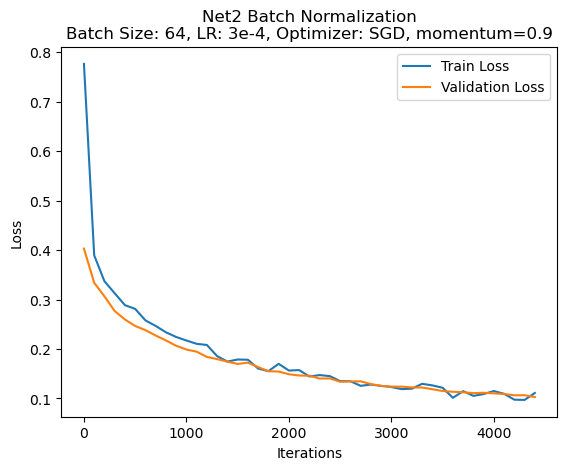

In [101]:
plot_learning_curve(batch_norm_loss_avg_train, batch_norm_loss_avg_valid, "Net2 Batch Normalization\nBatch Size: 64, LR: 3e-4, Optimizer: SGD, momentum=0.9")

---